In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [7]:
# Reading input

articles = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv')
transactions_train = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

In [8]:
pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv', nrows = 3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [9]:
pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv', nrows = 3)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...


In [10]:
pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv', nrows = 3)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2


In [12]:
# articles = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
# customers = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/customers.csv')
transactions_train

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [24]:
transactions_train['max_purc_date'] = transactions_train.groupby('customer_id')['t_dat'].transform('max')

transactions_train['min_purc_date'] = transactions_train.groupby('customer_id')['t_dat'].transform('min')

transactions_train['total_visits'] = transactions_train.groupby('customer_id')['t_dat'].transform('nunique')

transactions_train['total_item_bought'] = transactions_train.groupby('customer_id')['article_id'].transform('nunique')

transactions_train['max_year'] = transactions_train['max_purc_date'].str.slice(0,4).astype(int)

In [42]:
transactions_train.shape

(31788324, 10)

In [49]:
np.percentile(transactions_train[['customer_id','total_item_bought']].drop_duplicates()['total_item_bought'], 25)

3.0

In [46]:
transactions_train[['customer_id','total_item_bought']].drop_duplicates()['total_item_bought'].describe().transpose()

count    1.362281e+06
mean     2.004464e+01
std      3.198025e+01
min      1.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      2.400000e+01
max      1.346000e+03
Name: total_item_bought, dtype: float64

In [43]:
transactions_train[['customer_id','total_item_bought']].drop_duplicates()['total_item_bought'].mean()

20.04464497412795

In [51]:
transactions_train_filt = transactions_train[transactions_train['max_year'] == 2020]

transactions_train_filt = transactions_train_filt[transactions_train_filt['total_visits'] >= 10]

In [53]:
transactions_train_filt.shape

(20464700, 10)

In [56]:
transactions_train_filt = transactions_train_filt[transactions_train_filt['total_item_bought'] >= 10]

In [57]:
transactions_train_filt.shape

(20462951, 10)

In [58]:
transactions_train_filt['product_reach'] = transactions_train_filt.groupby('article_id')['customer_id'].transform('nunique')

In [65]:
np.percentile(transactions_train_filt[['article_id','product_reach']].drop_duplicates()['product_reach'], 25)

8.0

In [61]:
transactions_train_filt[['article_id','product_reach']].drop_duplicates()['product_reach'].describe()

count    101577.000000
mean        171.534324
std         395.757739
min           1.000000
25%           8.000000
50%          38.000000
75%         172.000000
max       17949.000000
Name: product_reach, dtype: float64

In [66]:
transactions_train_filt = transactions_train_filt[transactions_train_filt['product_reach'] > 8]

In [67]:
transactions_train_filt.shape

(20358515, 11)

In [22]:
cust_multiple_visits.groupby('t_dat').agg({'customer_id':'count'}).sort_values('customer_id',ascending=False)

,customer_id
t_dat,
1,447973
2,183116
3,113869
4,83255
5,65301
...,...
206,1
211,1
215,1


<AxesSubplot:ylabel='Count'>

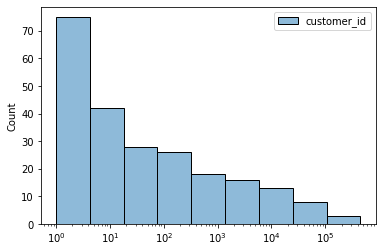

In [23]:
sns.histplot(cust_multiple_visits.groupby('t_dat').agg({'customer_id':'count'}), log_scale=True)

In [ ]:
np.percentile(cust_multiple_visits[cust_multiple_visits['t_dat'] > 10]['t_dat'], 0.99)

In [4]:
customer_group = cust_multiple_visits[(cust_multiple_visits['t_dat'] > 1) & (cust_multiple_visits['t_dat'] <= 50 )]['customer_id']

NameError: name 'cust_multiple_visits' is not defined

In [ ]:
customer_group.shape

In [5]:
selected_customers = pd.merge(transactions_train,customer_group, 
                              left_on = 'customer_id',
                              right_on = 'customer_id',
                              how = 'inner'
                              
                             )

NameError: name 'pd' is not defined

In [ ]:
import gc
del transactions_train
gc.collect()

In [ ]:
selected_customers['prod_count'] = selected_customers.groupby('customer_id')['article_id'].transform('nunique')

In [ ]:
selected_customers.head()

In [ ]:
selected_customers[['prod_count']].describe().transpose()

In [ ]:
selected_customers['article_id'].nunique()

In [ ]:
np.percentile(selected_customers[['prod_count']], 95)

In [ ]:
selected_customers = selected_customers[selected_customers['prod_count'].between(2,172)]

In [ ]:
selected_customers['customer_id'].nunique()

In [ ]:
selected_customers.head()